# Preparación

Carga de datasets y formulación de funciones a utilizar en el análisis.

### RMSE (Root Mean Squared Error):

Root Mean Squared Error entre dos arrays ignorando valores infinitos y nulos.

### FFT

Estimación simple de la densidad espectral de potencia (PSD)

### Dominant Power Band

Toma un espectro (frecuencias + PSD) y devuelve un intervalo [f_lo, f_hi] que contiene aproximadamente una fracción q de la potencia total.



In [ ]:

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy import signal
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import networkx as nx
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    return float(np.sqrt(mean_squared_error(y_true[m], y_pred[m])))

def fft_psd(x: np.ndarray, fs: float = 1.0):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    x = x - np.mean(x) if len(x) else x
    n = len(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    X = np.fft.rfft(x)
    psd = (np.abs(X) ** 2) / max(n, 1)
    return freqs, psd

def dominant_power_band(freqs: np.ndarray, psd: np.ndarray, q: float = 0.9, fmin_exclude: float = 0.0):
    freqs = np.asarray(freqs)
    psd = np.asarray(psd)
    m = freqs > fmin_exclude
    freqs2, psd2 = freqs[m], psd[m]
    if len(freqs2) < 3 or np.sum(psd2) <= 0:
        return (np.nan, np.nan)
    order = np.argsort(freqs2)
    freqs2, psd2 = freqs2[order], psd2[order]
    csum = np.cumsum(psd2)
    total = csum[-1]
    lo = np.searchsorted(csum, (1-q)*total/2)
    hi = np.searchsorted(csum, (1+q)*total/2)
    lo = int(np.clip(lo, 0, len(freqs2)-1))
    hi = int(np.clip(hi, 0, len(freqs2)-1))
    return (float(freqs2[lo]), float(freqs2[hi]))

# Carga
df_agro_clean = pd.read_csv("agro_clean.csv")
df_agro_noise = pd.read_csv("agro_noise.csv")
df_ener_clean = pd.read_csv("ener_clean.csv")
df_ener_noise = pd.read_csv("ener_noise.csv")

print("AGRO clean:", df_agro_clean.shape, "| cols:", len(df_agro_clean.columns))
print("AGRO noise:", df_agro_noise.shape, "| cols:", len(df_agro_noise.columns))
print("ENER clean:", df_ener_clean.shape, "| cols:", len(df_ener_clean.columns))
print("ENER noise:", df_ener_noise.shape, "| cols:", len(df_ener_noise.columns))


AGRO clean: (2000, 14) | cols: 14
AGRO noise: (2000, 14) | cols: 14
ENER clean: (2000, 14) | cols: 14
ENER noise: (2000, 14) | cols: 14


**Bloque 1:**  
1) Visualizamos sensores en un `scatter_mapbox` usando coordenadas del `agro_clean`.  
2) Codificamos **color = NDVI (Agro_5)** y **tamaño = Humedad (Agro_1)** para leer biomasa vs humedad en el espacio.  
3) Para responder si hay *patrón espacial* de biomasa baja, filtramos el 20% inferior de NDVI (umbral p20) y aplicamos DBSCAN, identificando clusters donde NDVI bajo se agrupa geográficamente.  

**Conclusión**
Aunque, visualmente, aparentemente, se presentan clusters pequeños, la diferencia en NDVI no es significativa en comparación a cualquier zona fuera de estos como para concluir que la baja biomasa tiene un patrón espacial.

In [18]:
latitud = "Latitude"
longitud = "Longitude"
ndvi_col = "Agro_5"
hum_col  = "Agro_1"

df_map = df_agro_clean.reset_index(drop=False).copy()

center = dict(
    lat=float(pd.to_numeric(df_map["Latitude"], errors="coerce").mean()),
    lon=float(pd.to_numeric(df_map["Longitude"], errors="coerce").mean())
)

fig = px.scatter_mapbox(
    df_map,
    lat=latitud, lon=longitud,
    color=ndvi_col,
    size=hum_col,
    size_max=18,
    zoom=9,
    center=center,
    mapbox_style="open-street-map",
    hover_data=[ndvi_col, hum_col]
)
fig.update_layout(margin=dict(l=0,r=0,t=0,b=0))
fig.show()

# Clustering de baja biomasa: NDVI bajo (p20) + DBSCAN geoespacial
thr = float(df_map[ndvi_col].quantile(0.20))
df_low = df_map.loc[df_map[ndvi_col] <= thr].copy()

coords = df_low[[latitud, longitud]].apply(pd.to_numeric, errors="coerce")
coords = coords.dropna()
coords_rad = np.radians(coords.to_numpy())

# eps ~ 1.5 km (ajustable)
earth_km = 6371.0
eps_km = 1.5
eps = eps_km / earth_km

db = DBSCAN(eps=eps, min_samples=10, metric="haversine")
labels = db.fit_predict(coords_rad)

df_low = df_low.loc[coords.index].copy()
df_low["cluster_low_ndvi"] = labels

summary = (
    df_low[df_low["cluster_low_ndvi"] != -1]
    .groupby("cluster_low_ndvi")
    .agg(n_points=("cluster_low_ndvi","size"),
         ndvi_mean=(ndvi_col,"mean"),
         lat_mean=(latitud,"mean"),
         lon_mean=(longitud,"mean"))
    .sort_values(["n_points","ndvi_mean"], ascending=[False, True])
)
print(f"Umbral NDVI bajo (p20): {thr:.4f}")
print("Clusters de NDVI bajo (DBSCAN; -1 = ruido/no cluster):")
print(summary)

fig2 = px.scatter_mapbox(
    df_low,
    lat=latitud, lon=longitud,
    color="cluster_low_ndvi",
    zoom=9,
    center=center,
    mapbox_style="open-street-map",
    hover_data=[ndvi_col, hum_col, "cluster_low_ndvi"]
)
fig2.update_layout(margin=dict(l=0,r=0,t=0,b=0))
fig2.show()

Umbral NDVI bajo (p20): 0.8354
Clusters de NDVI bajo (DBSCAN; -1 = ruido/no cluster):
                  n_points  ndvi_mean  lat_mean   lon_mean
cluster_low_ndvi                                          
1                       15   0.740094  6.219740 -75.320232
3                       14   0.770666  6.287724 -75.363507
2                       13   0.743680  6.176799 -75.345608
4                       13   0.751648  6.288079 -75.312613
8                       11   0.731319  6.128820 -75.411111
9                       10   0.724711  6.143662 -75.382305
7                       10   0.740585  6.246821 -75.340162
0                       10   0.742114  6.176963 -75.461531
5                       10   0.755512  6.188488 -75.415411
6                       10   0.756665  6.142275 -75.460214


**Bloque 2:**  
1) Corremos **ADF** sobre todas las columnas `Ener_*` del `ener_clean` para identificar estacionariedad (H0: raíz unitaria ⇒ no estacionaria).  
2) Para series con p-value > 0.05, calculamos media móvil y varianza móvil con ventana 50 para evidenciar cambios de nivel o cambios de volatilidad.  
3) Para `Ener_5` (Costo del Gas), buscamos drift o random walk con dos señales:  
   - ADF en nivel suele fallar (no estacionaria).  
   - ADF en diferencias suele pasar (estacionaria).  

**Conclusión**
La evidencia visual indica que Ener_5 se comporta como un random walk con drift positivo. La serie no oscila alrededor de una media fija sino que presenta una tendencia ascendente., y la media móvil se desplaza hacia arriba también, lo cual es típico de no estacionariedad. En el gráfico de la primera diferencia, los incrementos son estables alrededor de una linea horizontal, pero esa línea está por encima de cero (mean(Δ)=0.0106), lo que visualmente confirma un drift sobre un proceso tipo random walk. Se consideró la posibilidad de que la media fuese tan pequeña que pudiese ser obviada, pero al comparar con la desviación estandar y teniendo en cuenta la cantidad de pasos, a largo plazo dería significativa.


In [ ]:

ener_cols = [c for c in df_ener_clean.columns if str(c).startswith("Ener_")]
print("Ener_* detectadas:", sorted(ener_cols))

adf_rows = []
for c in sorted(ener_cols):
    s = pd.to_numeric(df_ener_clean[c], errors="coerce").dropna()
    stat, pval, usedlag, nobs, crit, icbest = adfuller(s, autolag="AIC")
    adf_rows.append({"serie": c, "adf_stat": stat, "p_value": pval, "nobs": nobs})

adf_df = pd.DataFrame(adf_rows).sort_values("p_value")
print("\nADF (ener_clean) ordenado por p-value:")
print(adf_df)

non_stationary = adf_df.loc[adf_df["p_value"] > 0.05, "serie"].tolist()
print("\nNo estacionarias (p>0.05):", non_stationary)

# Rolling mean/var (50) para las no estacionarias
W = 50
for c in non_stationary:
    rmean = df_ener_clean[c].rolling(W).mean()
    rvar  = df_ener_clean[c].rolling(W).var()

    plt.figure(figsize=(12,4))
    plt.plot(df_ener_clean[c].values, label=f"{c} (nivel)")
    plt.plot(rmean.values, label=f"Media móvil ({W})")
    plt.title(f"{c}: nivel + media móvil")
    plt.legend(); plt.grid(alpha=0.25); plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(rvar.values, label=f"Varianza móvil ({W})")
    plt.title(f"{c}: varianza móvil")
    plt.legend(); plt.grid(alpha=0.25); plt.show()


s = pd.to_numeric(df_ener_clean["Ener_5"], errors="coerce").dropna()
ds = s.diff().dropna()

p_level = adfuller(s, autolag="AIC")[1]
p_diff  = adfuller(ds, autolag="AIC")[1]
mu_diff = float(ds.mean())

print(f"\nEner_5 ADF p-value (nivel): {p_level:.6g}")
print(f"Ener_5 ADF p-value (Δ):     {p_diff:.6g}")
print(f"Media(ΔEner_5):             {mu_diff:.6g}")

rmean = s.rolling(W).mean()
plt.figure(figsize=(12,4))
plt.plot(s.values, label="Ener_5 (nivel)")
plt.plot(rmean.values, label=f"Media móvil ({W})")
plt.title("Ener_5: evidencia visual de drift (nivel cambia; media móvil se desplaza)")
plt.legend(); plt.grid(alpha=0.25); plt.show()

plt.figure(figsize=(12,4))
plt.plot(ds.values, label="ΔEner_5")
plt.axhline(mu_diff, linestyle="--", linewidth=1, label=f"mean(Δ)={mu_diff:.4f}")
plt.title("Ener_5: primera diferencia (drift si mean(Δ) ≠ 0 y Δ es estacionaria)")
plt.legend(); plt.grid(alpha=0.25); plt.show()


In [ ]:
ds.describe()

**Bloque 3:**  
1) Estimamos la **PSD** por FFT para ver en qué frecuencias está la energía de la señal.  
2) Para localizar el ruido inyectado, analizamos el residual entre limpio y ruidoso. Su PSD revela la “firma” espectral del ruido.  
3) Reportamos un intervalo de frecuencias que contiene ~90% de la potencia del ruido (banda dominante) y lo respaldamos con espectrograma, donde el ruido aparece como energía concentrada en un rango de frecuencias específico.

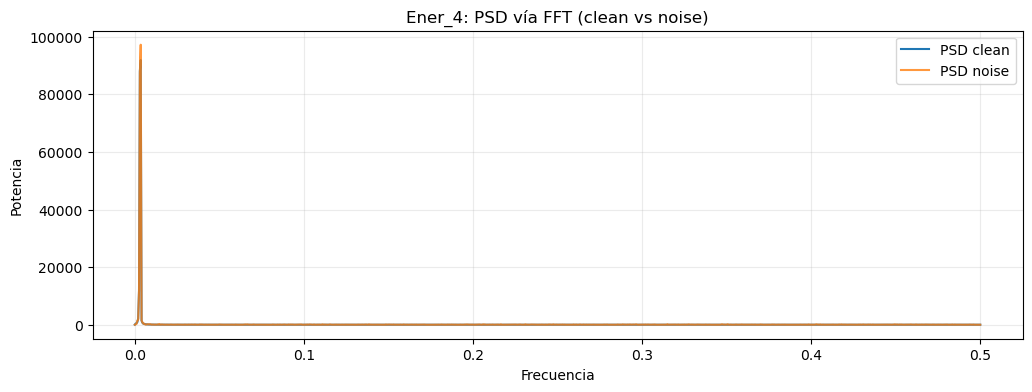

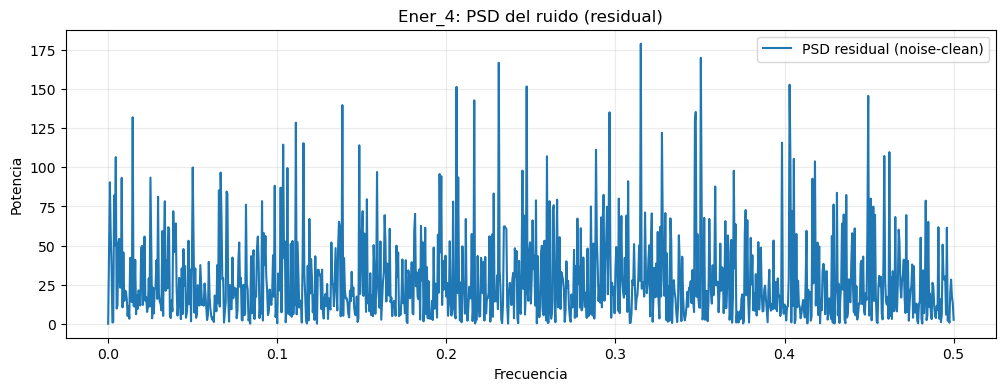

Banda ~90% de potencia del ruido (residual): [0.021500, 0.466500] (unidades de fs=1.0)


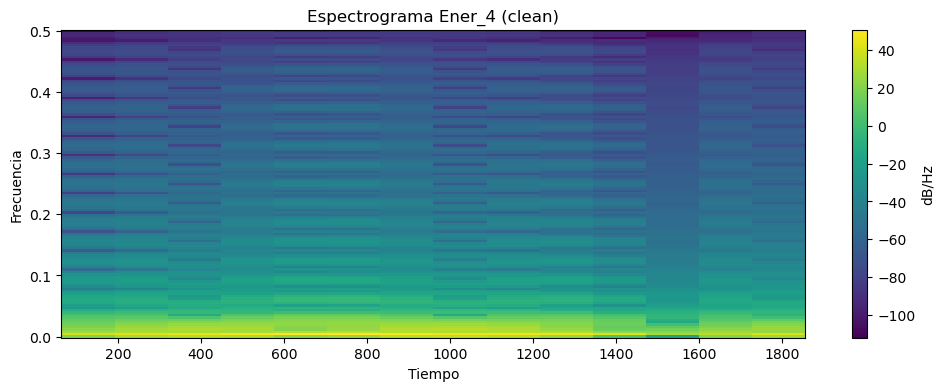

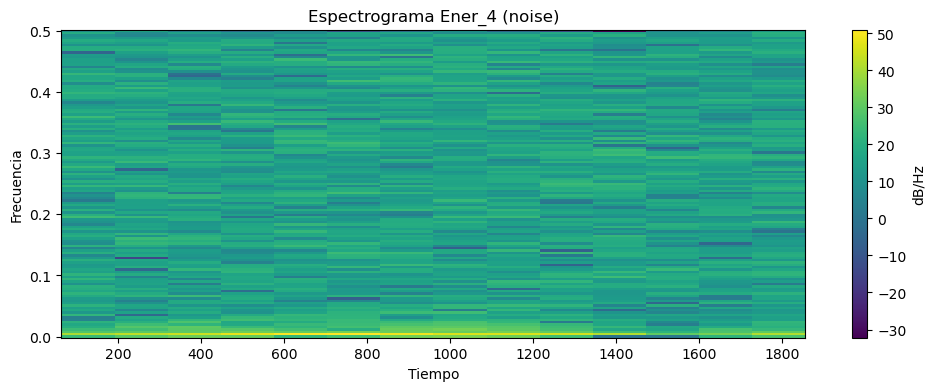

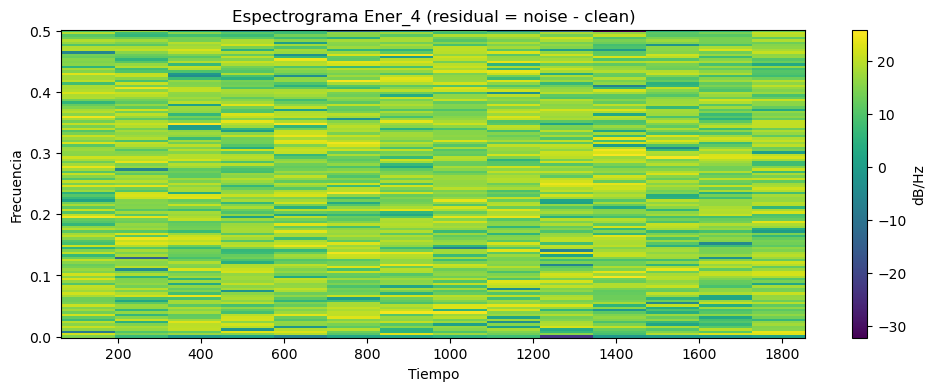

In [19]:
fs = 1.0 
clean = pd.to_numeric(df_ener_clean["Ener_4"], errors="coerce").dropna().to_numpy()
noisy = pd.to_numeric(df_ener_noise["Ener_4"], errors="coerce").dropna().to_numpy()

n = min(len(clean), len(noisy))
clean = clean[:n]
noisy = noisy[:n]
resid = noisy - clean

# PSD FFT
f_c, psd_c = fft_psd(clean, fs=fs)
f_n, psd_n = fft_psd(noisy, fs=fs)
f_r, psd_r = fft_psd(resid, fs=fs)

plt.figure(figsize=(12,4))
plt.plot(f_c, psd_c, label="PSD clean")
plt.plot(f_n, psd_n, label="PSD noise", alpha=0.8)
plt.title("Ener_4: PSD vía FFT (clean vs noise)")
plt.xlabel("Frecuencia"); plt.ylabel("Potencia")
plt.legend(); plt.grid(alpha=0.25); plt.show()

plt.figure(figsize=(12,4))
plt.plot(f_r, psd_r, label="PSD residual (noise-clean)")
plt.title("Ener_4: PSD del ruido (residual)")
plt.xlabel("Frecuencia"); plt.ylabel("Potencia")
plt.legend(); plt.grid(alpha=0.25); plt.show()

band = dominant_power_band(f_r, psd_r, q=0.90, fmin_exclude=0.0)
print(f"Banda ~90% de potencia del ruido (residual): [{band[0]:.6f}, {band[1]:.6f}] (unidades de fs={fs})")

f1, t1, S1 = signal.spectrogram(clean, fs=fs, nperseg=256, noverlap=128, scaling="density")
f2, t2, S2 = signal.spectrogram(noisy, fs=fs, nperseg=256, noverlap=128, scaling="density")
f3, t3, S3 = signal.spectrogram(resid, fs=fs, nperseg=256, noverlap=128, scaling="density")

plt.figure(figsize=(12,4))
plt.pcolormesh(t1, f1, 10*np.log10(S1 + 1e-12), shading="auto")
plt.title("Espectrograma Ener_4 (clean)")
plt.ylabel("Frecuencia"); plt.xlabel("Tiempo")
plt.colorbar(label="dB/Hz"); plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(t2, f2, 10*np.log10(S2 + 1e-12), shading="auto")
plt.title("Espectrograma Ener_4 (noise)")
plt.ylabel("Frecuencia"); plt.xlabel("Tiempo")
plt.colorbar(label="dB/Hz"); plt.show()

plt.figure(figsize=(12,4))
plt.pcolormesh(t3, f3, 10*np.log10(S3 + 1e-12), shading="auto")
plt.title("Espectrograma Ener_4 (residual = noise - clean)")
plt.ylabel("Frecuencia"); plt.xlabel("Tiempo")
plt.colorbar(label="dB/Hz"); plt.show()


**Bloque 4:**  
1) Alineamos ambas series (por orden y por Source_Node) y filtramos `Agro_3` con un **Butterworth low-pass** usando `filtfilt` (cero desfase).  
2) Medimos **RMSE**:  
   - `RMSE(noisy vs clean)` vs `RMSE(filtered vs clean)` para cuantificar limpieza. 

**Conclusión**


El RMSE entre la serie filtrada y la original es 0.850975. Sí, el filtrado mejora la capacidad predictiva del modelo. El RMSE de predicción 1-step baja de 3.504124 a 0.022371.

In [ ]:

dfc = df_agro_clean[["Source_Node", "Agro_3"]].rename(columns={"Agro_3": "Agro_3_clean"}).copy()
dfn = df_agro_noise[["Source_Node", "Agro_3"]].rename(columns={"Agro_3": "Agro_3_noise"}).copy()

dfc["seq"] = dfc.groupby("Source_Node").cumcount()
dfn["seq"] = dfn.groupby("Source_Node").cumcount()

aligned = (
    dfc.merge(dfn, on=["Source_Node", "seq"], how="inner")
       .dropna(subset=["Agro_3_clean", "Agro_3_noise"])
)

print("len(clean), len(noise), len(aligned):",
      len(df_agro_clean), len(df_agro_noise), len(aligned))

clean = pd.to_numeric(aligned["Agro_3_clean"], errors="coerce").to_numpy()
noisy = pd.to_numeric(aligned["Agro_3_noise"], errors="coerce").to_numpy()

m = np.isfinite(clean) & np.isfinite(noisy)
clean, noisy = clean[m], noisy[m]
resid = noisy - clean

# 2) Estimar cutoff con PSD (FFT) comparando potencia del ruido vs señal
fs = 1.0 
f_c, psd_clean = fft_psd(clean, fs=fs)
f_r, psd_resid = fft_psd(resid, fs=fs)

ratio = psd_resid / (psd_clean + 1e-12)
idx = np.where((f_c > 0) & (ratio > 1.0))[0]
cutoff = float(f_c[idx[0]]) if len(idx) else 0.10 * (fs / 2)
cutoff = np.clip(cutoff, 0.02 * (fs / 2), 0.45 * (fs / 2))
Wn = cutoff / (fs / 2)

# 3) Filtro Butterworth (orden 4) + filtfilt (cero desfase)
b, a = signal.butter(N=4, Wn=Wn, btype="lowpass")
filt = signal.filtfilt(b, a, noisy)

# 4) RMSE contra clean
rmse_noisy = rmse(clean, noisy)
rmse_filt  = rmse(clean, filt)

print(f"Cutoff elegido: {cutoff:.6f} (Wn={Wn:.6f}, fs={fs})")
print(f"RMSE(noisy vs clean):     {rmse_noisy:.6f}")
print(f"RMSE(filtered vs clean):  {rmse_filt:.6f}")

plt.figure(figsize=(12,4))
plt.plot(clean, label="Agro_3 clean")
plt.plot(noisy, alpha=0.6, label="Agro_3 noise")
plt.plot(filt, linewidth=2, label="Agro_3 filtrada (Butterworth)")
plt.title("Agro_3: clean vs noise vs filtrada (alineación Source_Node+seq)")
plt.legend(); plt.grid(alpha=0.25); plt.show()

# 5) Evaluación predictiva: baseline 1-step con lags + Ridge
def make_lag_xy(x, lags=12):
    x = np.asarray(x, dtype=float)
    X, y = [], []
    for i in range(lags, len(x)-1):
        X.append(x[i-lags:i])
        y.append(x[i+1])
    return np.array(X), np.array(y)

lags = 12
Xn, yn = make_lag_xy(noisy, lags=lags)
Xf, yf = make_lag_xy(filt,  lags=lags)

split = int(0.8 * len(yn))
model = Ridge(alpha=1.0)

model.fit(Xn[:split], yn[:split])
pred_n = model.predict(Xn[split:])
rmse_pred_noisy = rmse(yn[split:], pred_n)

model.fit(Xf[:split], yf[:split])
pred_f = model.predict(Xf[split:])
rmse_pred_filt = rmse(yf[split:], pred_f)

print(f"RMSE pred 1-step (noisy):    {rmse_pred_noisy:.6f}")
print(f"RMSE pred 1-step (filtered): {rmse_pred_filt:.6f}")


**Lógica técnica (bloque 5):**  
1) Construimos un **DiGraph** con aristas `Source_Node → Target_Node`.
2) Calculamos:  
   - **Degree centrality** (importancia por conectividad).  
   - **Betweenness centrality** (importancia por intermediación en caminos mínimos).  

**Conclusión**

No hay un cuello de botella claro si se mira desde la perspectiva del betweenness. Casi todos los nodos tienen conexiones directas a otros. Si se mira desde la perspectiva de la centralidad, el nodo con más tráfico es el 119.

In [ ]:

def build_graph(df: pd.DataFrame) -> nx.DiGraph:
    if "Source_Node" not in df.columns or "Target_Node" not in df.columns:
        raise ValueError("Faltan Source_Node/Target_Node en el dataframe.")
    edges = df[["Source_Node","Target_Node"]].dropna()
    G = nx.DiGraph()
    G.add_edges_from(edges.itertuples(index=False, name=None))
    return G

try:
    G = build_graph(df_ener_clean.reset_index(drop=False))
    graph_origin = "ener_clean"
except Exception:
    G = build_graph(df_agro_clean.reset_index(drop=False))
    graph_origin = "agro_clean"

deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G, normalized=True)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_btw = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)[:10]

bottleneck_node, bottleneck_score = top_btw[0]
print(f"Grafo construido desde: {graph_origin}")
print("Top 10 Degree Centrality:")
for n, v in top_deg:
    print(f"  {n}: {v:.6f}")
print("\nTop 10 Betweenness Centrality:")
for n, v in top_btw:
    print(f"  {n}: {v:.6f}")
print(f"\nNodo Cuello de Botella (max betweenness): {bottleneck_node} (score={bottleneck_score:.6f})")

# Visualización del grafo
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico 1: Degree Centrality
ax1 = axes[0]
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
node_sizes_deg = [deg_cent.get(node, 0) * 3000 + 100 for node in G.nodes()]
nodes_deg = nx.draw_networkx_nodes(G, pos, node_size=node_sizes_deg, node_color=list(deg_cent.values()),
                                    cmap="Reds", ax=ax1, alpha=0.8)
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.3, arrowsize=10, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax1)
ax1.set_title("Grafo: Tamaño por Degree Centrality", fontsize=12, fontweight="bold")
ax1.axis("off")
cbar1 = plt.colorbar(nodes_deg, ax=ax1, label="Degree Centrality")

# Gráfico 2: Betweenness Centrality (con bottleneck destacado)
ax2 = axes[1]
node_colors_btw = ["red" if node == bottleneck_node else "lightblue" for node in G.nodes()]
node_sizes_btw = [btw_cent.get(node, 0) * 3000 + 100 for node in G.nodes()]
edgecolors_btw = ["darkred" if node == bottleneck_node else "black" for node in G.nodes()]
nodes_btw = nx.draw_networkx_nodes(G, pos, node_size=node_sizes_btw, node_color=node_colors_btw,
                                    ax=ax2, alpha=0.8, edgecolors=edgecolors_btw)
nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.3, arrowsize=10, edge_color="gray")
labels = {node: f"{node}" if node == bottleneck_node else node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="bold" if bottleneck_node in labels else "normal", ax=ax2)
ax2.set_title(f"Grafo: Tamaño por Betweenness Centrality\n(Nodo rojo = Cuello de Botella)", fontsize=12, fontweight="bold")
ax2.axis("off")
cbar2 = plt.colorbar(nodes_btw, ax=ax2, label="Betweenness Centrality")

plt.tight_layout()
plt.show()


In [ ]:

def build_graph_strict(df, source_col="Source_Node", target_col="Target_Node") -> nx.DiGraph:
    missing = [c for c in [source_col, target_col] if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas requeridas para el grafo: {missing}. "
                         f"Columnas disponibles: {list(df.columns)}")

    edges = df[[source_col, target_col]].dropna()
    if edges.empty:
        raise RuntimeError("No hay aristas válidas (todas las filas tienen NaN en Source/Target).")

    G = nx.DiGraph()
    G.add_edges_from(edges.itertuples(index=False, name=None))

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        raise RuntimeError(f"Grafo vacío. Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")

    return G

# ✅ Elige explícitamente el dataset (aquí: energía). Si falla, se detiene.
G = build_graph_strict(df_ener_clean.reset_index(drop=True))
graph_origin = "ener_clean"

deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G, normalized=True)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_btw = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)[:10]

bottleneck_node, bottleneck_score = top_btw[0]

print(f"Grafo construido desde: {graph_origin}")
print("Top 10 Degree Centrality:")
for n, v in top_deg:
    print(f"  {n}: {v:.6f}")
print("\nTop 10 Betweenness Centrality:")
for n, v in top_btw:
    print(f"  {n}: {v:.6f}")
print(f"\nNodo Cuello de Botella (max betweenness): {bottleneck_node} (score={bottleneck_score:.6f})")

# Visualización (2 paneles)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Panel 1: Degree Centrality
ax1 = axes[0]
node_sizes_deg = [deg_cent.get(node, 0) * 3000 + 100 for node in G.nodes()]
nodes_deg = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes_deg, node_color=list(deg_cent.values()),
    cmap="Reds", ax=ax1, alpha=0.8
)
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.3, arrows=True, arrowsize=10, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax1)
ax1.set_title("Grafo: Tamaño/Color por Degree Centrality", fontsize=12, fontweight="bold")
ax1.axis("off")
plt.colorbar(nodes_deg, ax=ax1, label="Degree Centrality")

# Panel 2: Betweenness Centrality (bottleneck en rojo)
ax2 = axes[1]
node_colors_btw = ["red" if node == bottleneck_node else "lightblue" for node in G.nodes()]
node_sizes_btw = [btw_cent.get(node, 0) * 3000 + 100 for node in G.nodes()]
edgecolors_btw = ["darkred" if node == bottleneck_node else "black" for node in G.nodes()]

nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes_btw, node_color=node_colors_btw,
    ax=ax2, alpha=0.85, edgecolors=edgecolors_btw
)
nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.3, arrows=True, arrowsize=10, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax2)
ax2.set_title("Grafo: Tamaño por Betweenness (rojo=bottleneck)", fontsize=12, fontweight="bold")
ax2.axis("off")

plt.tight_layout()
plt.show()
